In [40]:
!pip install shap -q

In [84]:
!pip install phik -q

### Task
Find features that are randomly generated

In [85]:
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

In [71]:
path = 'https://stepik.org/media/attachments/lesson/779915/fs_task1_10f.csv'

path = 'https://stepik.org/media/attachments/lesson/779915/fs_task2_22f.csv'

df = pd.read_csv(path)
df.shape

(1870, 22)

In [72]:
df.sample(2)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target_reg,target_class
1023,0,4.396609,169,1,17.188206,114464,157.965961,1.075698e+07,0,0,...,2017,184.696584,2020,0.00,1,174,24,5.80,24.43,electro_bug
482,0,5.324368,171,1,7.142872,62004,191.229614,2.248098e+07,0,0,...,2014,106.490185,2015,1.11,1,174,20,3.48,37.57,break_bug


In [79]:
target = 'target_reg'

In [135]:
df.nunique()

feature_0          2
feature_1       1788
feature_2         28
feature_3          2
feature_4       1870
feature_5       1844
feature_6       1870
feature_7       1870
feature_8          2
feature_9          2
feature_10         2
feature_11        50
feature_12         7
feature_13      1566
feature_14         9
feature_15        86
feature_16         2
feature_17         1
feature_18        26
feature_19       253
target_reg      1543
target_class       9
random_norm     1870
random_cat         4
dtype: int64

### EDA

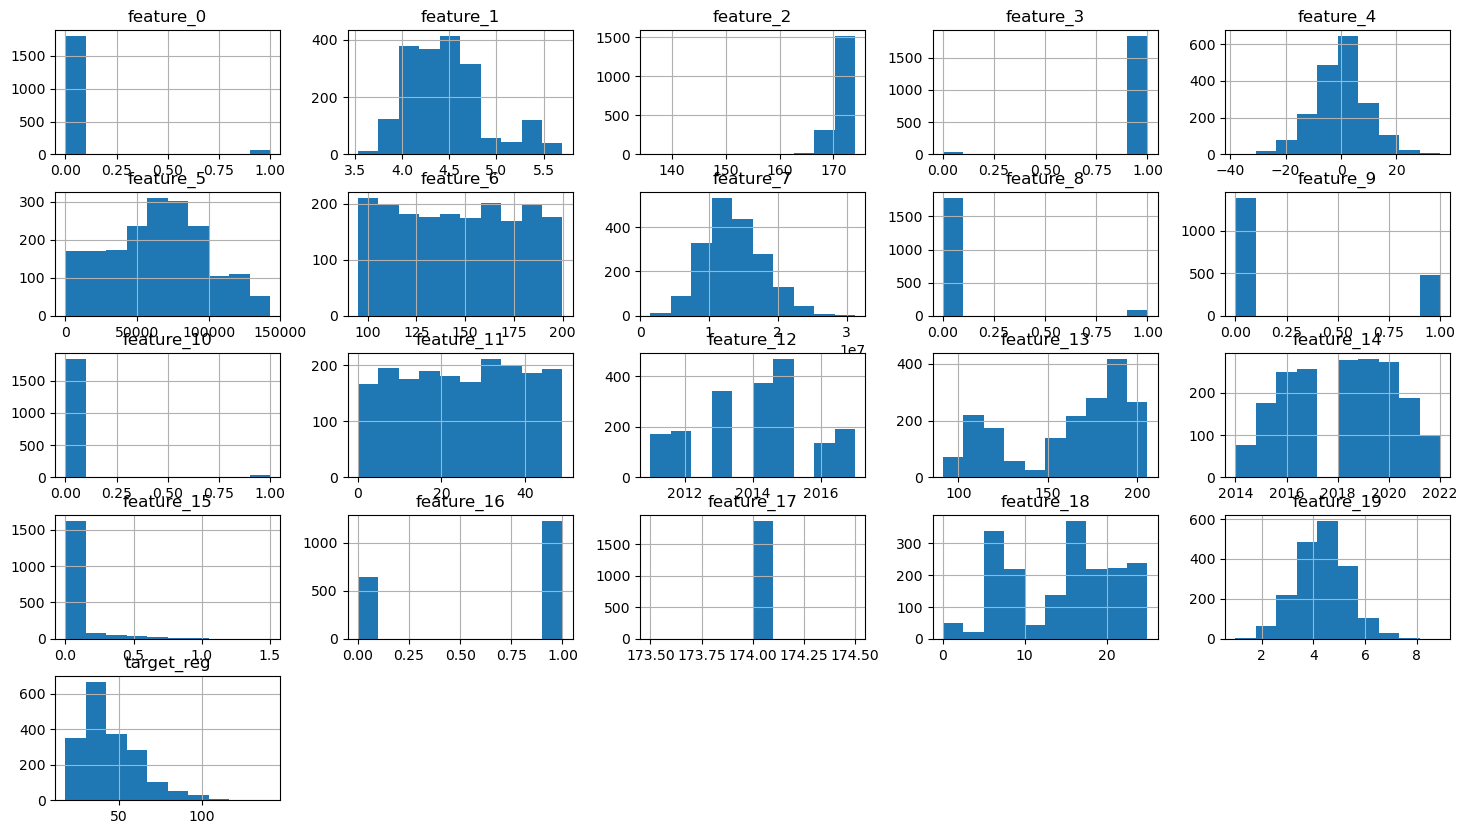

In [77]:
df.hist(figsize=(18, 10), layout=(-1, 5));

<AxesSubplot: >

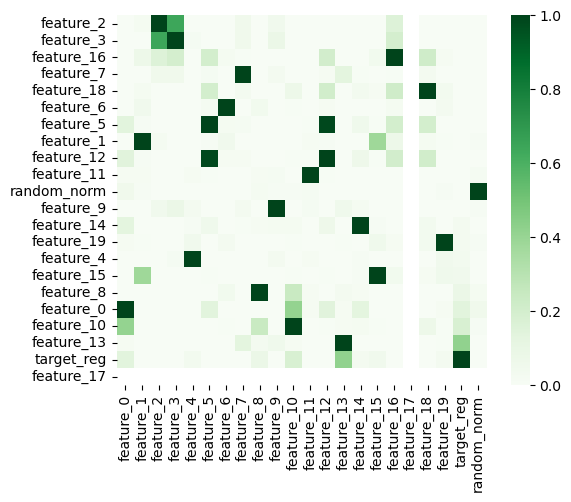

In [82]:
corrs = df.dropna().corr(numeric_only=True).round(3).sort_values('target_reg')
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

In [120]:
c1 = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'target_reg']

c2 = ['feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'random_norm', 'random_cat', 'target_reg']

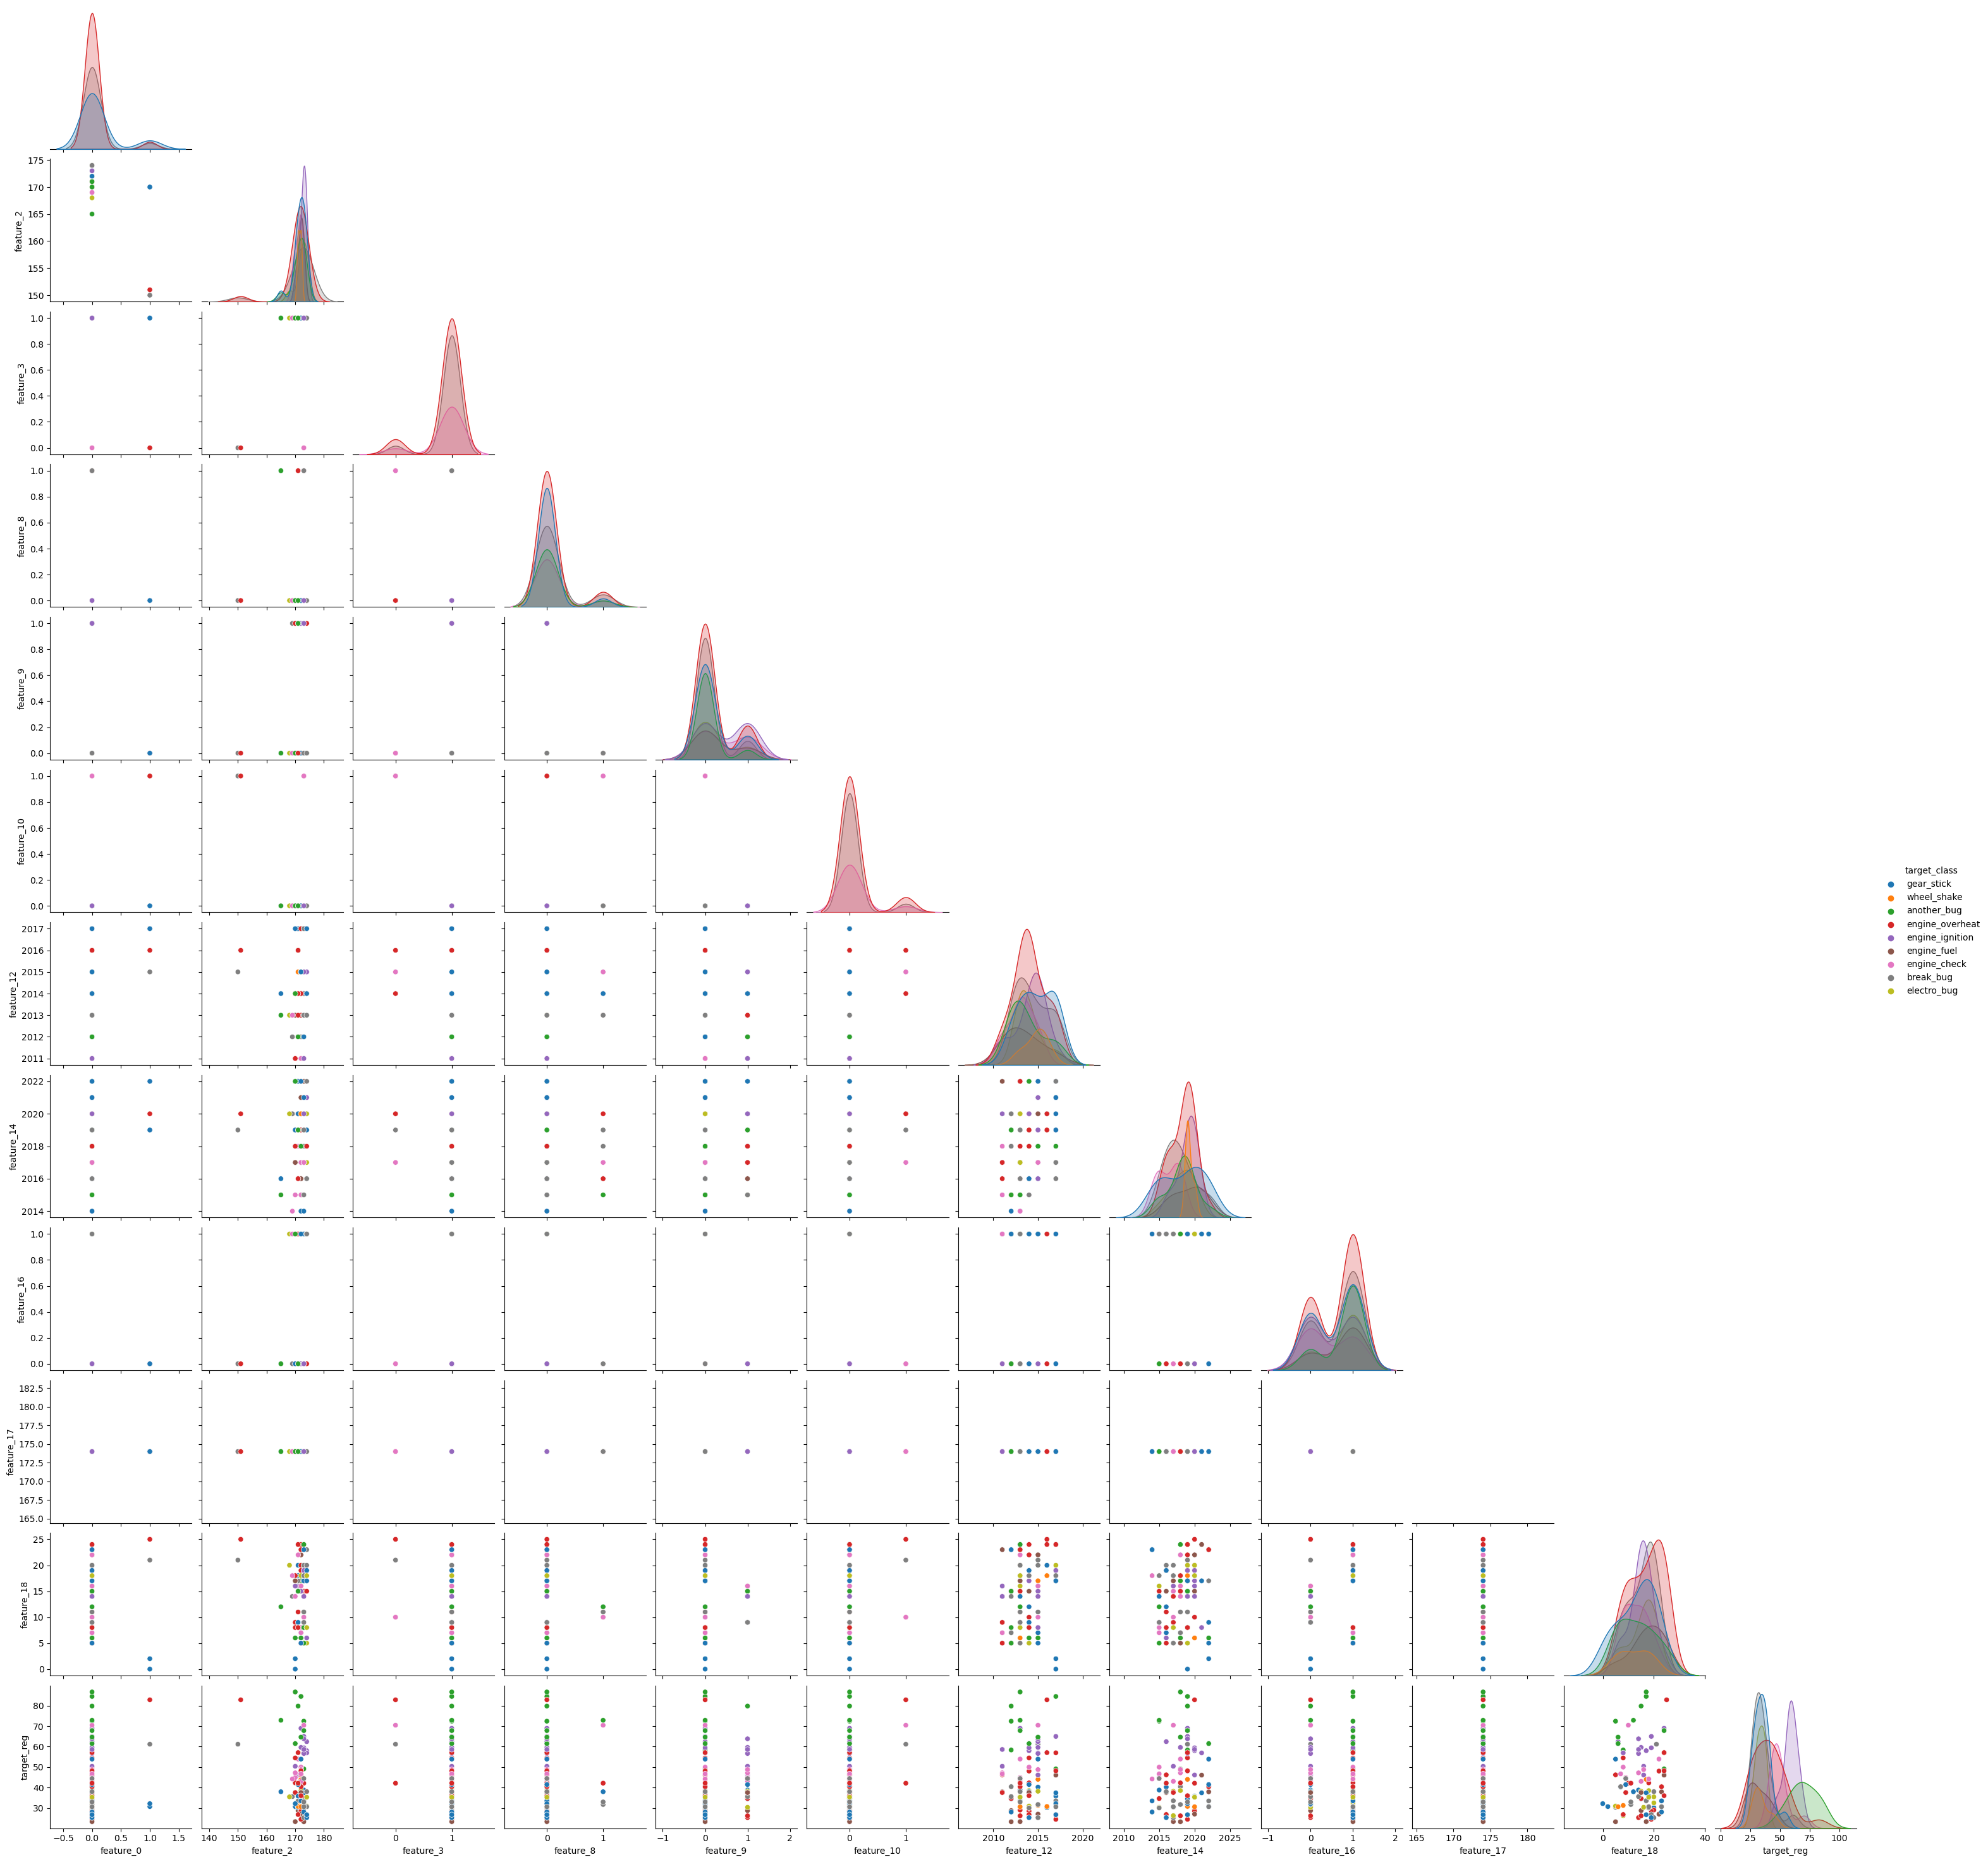

In [133]:
sns.pairplot(
    df.sample(100)[cat_cols + ['target_class', 'target_reg']],
    corner=True,
    hue='target_class',
);

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg', 'random_norm']


/home/katsiaryna/.conda/envs/ranking/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable feature_17 for analysis 1. Dropping this column
  warnings.warn(


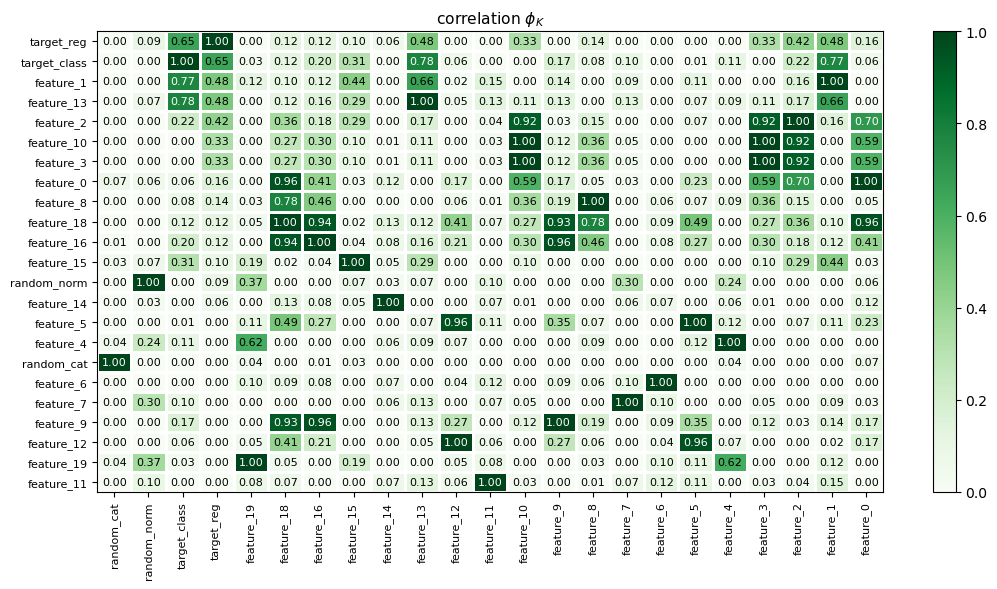

In [134]:
phik_overview = df.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [91]:
significance_overview.loc['target_class'].sort_values()[:5]

random_cat    -1.5
feature_14    -0.9
feature_6     -0.5
feature_11    -0.4
random_norm   -0.2
Name: target_class, dtype: float64

In [92]:
significance_overview.loc['target_reg'].sort_values()[:5]

feature_9    -1.4
random_cat   -0.5
feature_4    -0.5
feature_5    -0.5
feature_19   -0.3
Name: target_reg, dtype: float64

### Add random

In [81]:
# df['random_int'] = np.random.randint(-20, 200, df.shape[0]) # Целочисленный признак
# df['random_num'] = np.random.random(size = df.shape[0]) # Признак типа float с равномерным распределением
df['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = df.shape[0]) # Признак с нормальным распределением
df['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = df.shape[0]) # Категориальный признак str формата с дисбалансом
# df['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = df.shape[0]) # Численный категориальный признак


### Catboost feature importance

In [110]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split

In [126]:
drop_cols = ['target_reg',  'target_class',]
cat_cols = ['feature_0',
 'feature_2',
 'feature_3',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_12',
 'feature_14',
 'feature_16',
 'feature_17',
 'feature_18',
 'random_cat'
           ]

X = df.drop(drop_cols, axis=1)
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [127]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.10885
0:	learn: 1.8738953	test: 1.8562170	best: 1.8562170 (0)	total: 100ms	remaining: 1m 40s
100:	learn: 0.4309990	test: 0.5383508	best: 0.5383508 (100)	total: 9.07s	remaining: 1m 20s
200:	learn: 0.2962923	test: 0.5301227	best: 0.5255195 (133)	total: 19.6s	remaining: 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5255194785
bestIteration = 133

Shrink model to first 134 iterations.


In [128]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,feature_13,37.507460
1,feature_1,30.718604
2,feature_15,14.600534
3,feature_2,3.919006
4,feature_18,2.459948
5,feature_12,2.342307
6,feature_14,1.807878
7,random_cat,1.487220
8,feature_4,0.970473
9,feature_16,0.768347


### Sklearn permutation_importance

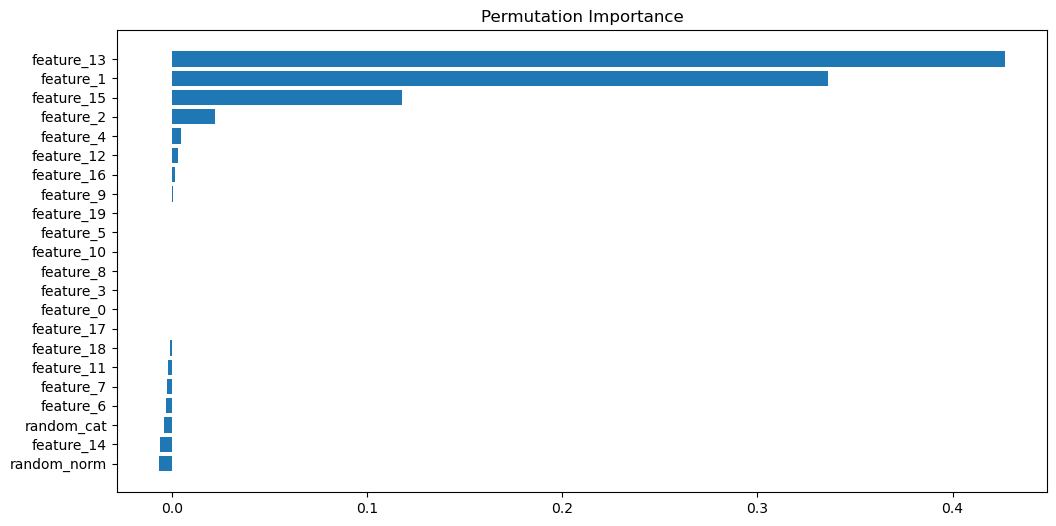

In [129]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

### Shap values

In [130]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols, feature_names=X_test.columns.tolist())
shap_values = explainer(val_dataset)

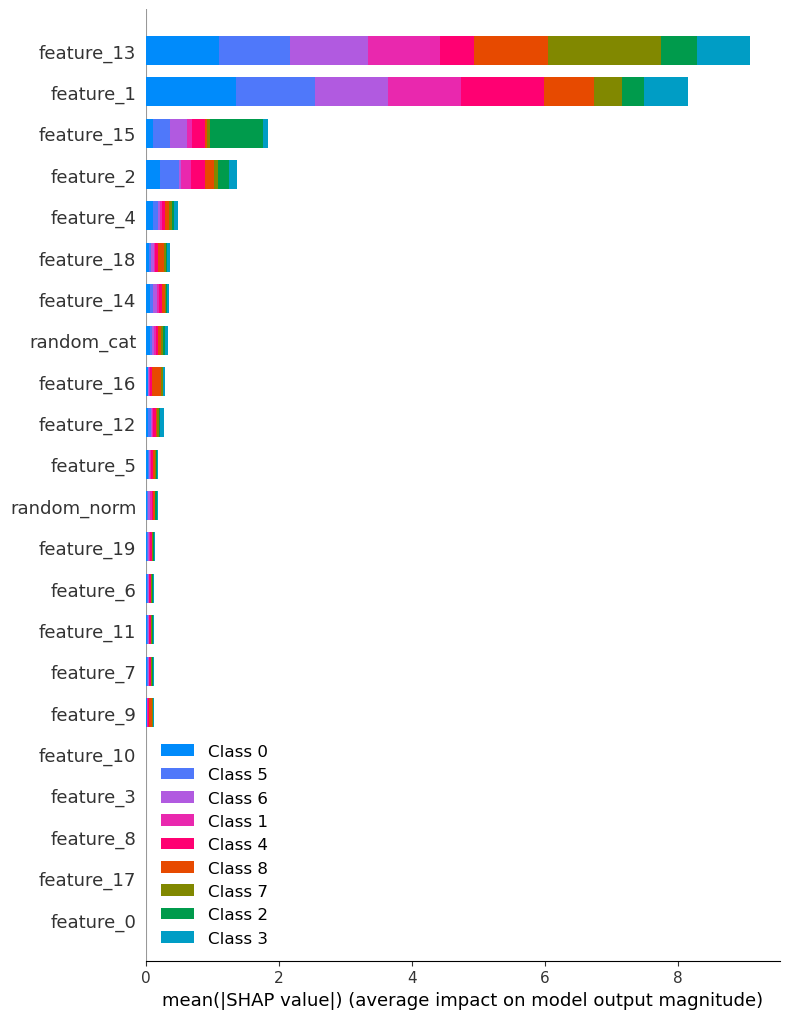

In [131]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display=22);